## 1. 데이터 확인

## 1. 데이터 확인

### 필수 라이브러리

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 무시

In [77]:
df_train_origin = pd.read_csv("./data/train.csv") # 학습용 데이터
df_test_origin = pd.read_csv("./data/submission.csv") # 테스트 데이터(제출파일의 데이터)

In [78]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

## 2. 데이터 전처리

### 각 변수별 확인

In [79]:
df_train = pd.read_csv('./data/Ch2/df_train.csv')
df_test = pd.read_csv('./data/Ch2/df_test.csv')

In [80]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            59299 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  float64
 9   it_strategic_ver         59299 non-null  float64
 10  idit_strategic_ver       59299 non-null  float64
 11  customer_job             59299 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             59299 non-null  object 
 14  product_category      

## 3. 피처엔지니어링

### 레이블 인코딩

In [81]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

# df_train과 df_test를 복사하여 새로운 데이터프레임을 생성
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

# 레이블 인코딩 적용
for col in label_columns:
    encoder = LabelEncoder()
    combined_data = pd.concat([df_train_encoded[col], df_test_encoded[col]])
    encoder.fit(combined_data)
    df_train_encoded[col] = encoder.transform(df_train_encoded[col])
    df_test_encoded[col] = encoder.transform(df_test_encoded[col])


'com_reg_ver_win_rate' 에 대한 결측치 처리

In [82]:
from sklearn.ensemble import RandomForestRegressor

def fill_missing_values(df):
    # 데이터에서 결측치가 없는 행과 결측치가 있는 행 분리
    train_data = df[df['com_reg_ver_win_rate'].notna()]
    test_data = df[df['com_reg_ver_win_rate'].isna()]

    # 'com_reg_ver_win_rate'를 예측하는 데 사용할 피처 선택
    features = ['business_area', 'business_unit', 'customer_country.1']   

    # 훈련 데이터와 테스트 데이터 준비
    X_train = train_data[features]
    y_train = train_data['com_reg_ver_win_rate']
    X_test = test_data[features]

    # 랜덤 포레스트 모델 생성 및 훈련
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)

    # 모델을 사용해 결측치 예측
    predicted_values = model.predict(X_test)

    # 예측값으로 결측치 대체
    df.loc[df['com_reg_ver_win_rate'].isna(), 'com_reg_ver_win_rate'] = predicted_values


# df_train_encoded에 대한 데이터 처리
fill_missing_values(df_train_encoded)

# df_test_encoded에 대한 데이터 처리
fill_missing_values(df_test_encoded)

In [83]:
print(df_train_encoded['com_reg_ver_win_rate'].isnull().sum())

0


In [84]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   int32  
 3   business_unit            5271 non-null   int32  
 4   com_reg_ver_win_rate     5271 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            5271 non-null   int32  
 7   enterprise               5271 non-null   int32  
 8   historical_existing_cnt  5271 non-null   float64
 9   id_strategic_ver         5271 non-null   float64
 10  it_strategic_ver         5271 non-null   float64
 11  idit_strategic_ver       5271 non-null   float64
 12  customer_job             5271 non-null   int32  
 13  lead_desc_length         5271 non-null   int64  
 14  inquiry_type            

### 파생변수 생성

In [85]:
## strategic ##
# 변수 'id_business_area' 생성
df_train_encoded['id_business_area'] = df_train_encoded['id_strategic_ver'] * df_train_encoded['business_subarea'] 
df_test_encoded['id_business_area'] = df_test_encoded['id_strategic_ver'] * df_test_encoded['business_subarea'] 

# 변수 'it_business_area' 생성
df_train_encoded['it_business_area'] = df_train_encoded['it_strategic_ver']  * df_train_encoded['business_subarea'] 
df_test_encoded['it_business_area'] = df_test_encoded['it_strategic_ver'] * df_test_encoded['business_subarea']

# 변수 'idit_business_area' 생성
df_train_encoded['idit_business_area'] = df_train_encoded['idit_strategic_ver'] * df_train_encoded['business_area'] * df_train_encoded['business_unit']
df_test_encoded['idit_business_area'] = df_test_encoded['idit_strategic_ver'] * df_test_encoded['business_area'] * df_test_encoded['business_unit']


## ver ##
# 변수 'ver_cus_business_area' 생성
df_train_encoded['ver_cus_business_area'] = df_train_encoded['ver_cus'] * df_train_encoded['business_area']
df_test_encoded['ver_cus_business_area'] = df_test_encoded['ver_cus'] * df_test_encoded['business_area']

# 변수 'ver_pro_product_category' 생성
df_train_encoded['ver_pro_product_category'] = df_train_encoded['ver_pro'] * df_train_encoded['product_category'] * df_train_encoded['business_area']
df_test_encoded['ver_pro_product_category'] = df_test_encoded['ver_pro'] * df_test_encoded['product_category'] * df_test_encoded['business_area']

# 변수 'ver_win_business_area' 생성
df_train_encoded['ver_win_business_area'] = df_train_encoded['ver_win_rate_x'] * df_train_encoded['business_area']
df_test_encoded['ver_win_business_area'] = df_test_encoded['ver_win_rate_x'] * df_test_encoded['business_area']

# 변수 'ver_ratio_business_area' 생성
df_train_encoded['ver_ratio_business_area'] = df_train_encoded['ver_win_ratio_per_bu'] * df_train_encoded['business_area'] * df_train_encoded['business_unit']
df_test_encoded['ver_ratio_business_area'] = df_test_encoded['ver_win_ratio_per_bu'] * df_test_encoded['business_area'] * df_test_encoded['business_unit']


## 추가 고려 ## 
# 변수 'subcategory_modelname' 생성
df_train_encoded['category_modelname'] = df_train_encoded['product_category'] * df_train_encoded['product_subcategory'] * df_train_encoded['product_modelname']
df_test_encoded['category_modelname'] = df_test_encoded['product_category'] * df_test_encoded['product_subcategory'] * df_test_encoded['product_modelname']


데이터의 분포를 시각화를 통해 'business_subarea' 와 "strategic_ver" 계열 데이터 간의 관계를 확인

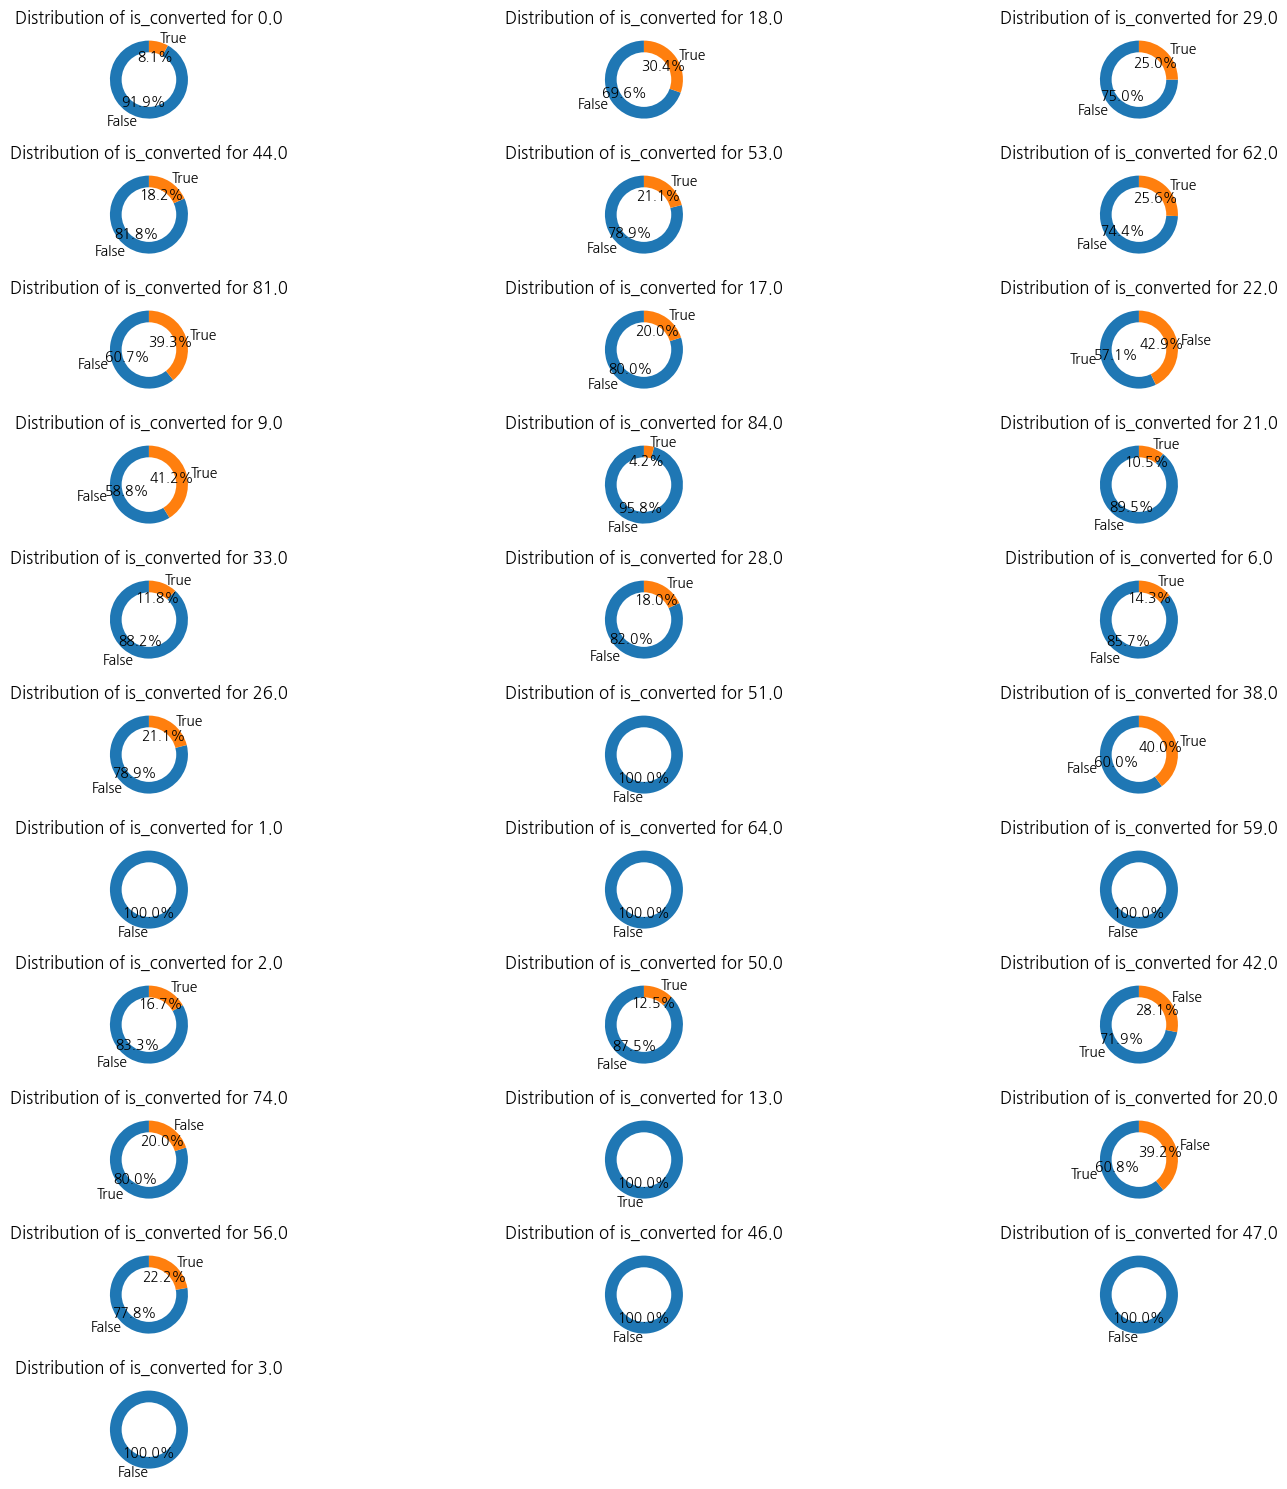

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# it_business_area의 고유한 값들을 가져옵니다.
business_areas = df_train_encoded['id_business_area'].unique()

# 행과 열의 수를 계산합니다.
n = len(business_areas)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))

# axs를 항상 2차원 배열로 처리합니다.
if nrows == 1:
    axs = axs[np.newaxis, :]
if ncols == 1:
    axs = axs[:, np.newaxis]

for i, area in enumerate(business_areas):
    # 특정 business_area에 해당하는 데이터만 선택합니다.
    subset = df_train_encoded[df_train_encoded['id_business_area'] == area]
    
    # is_converted의 값에 따라 데이터를 그룹화하고 카운트합니다.
    counts = subset['is_converted'].value_counts()
    
    # 도넛 차트를 생성합니다.
    ax = axs[i // ncols, i % ncols]
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Distribution of is_converted for {area}')
    ax.add_artist(plt.Circle((0,0),0.70,fc='white'))

# 빈 subplot을 숨깁니다.
for j in range(i+1, nrows*ncols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()


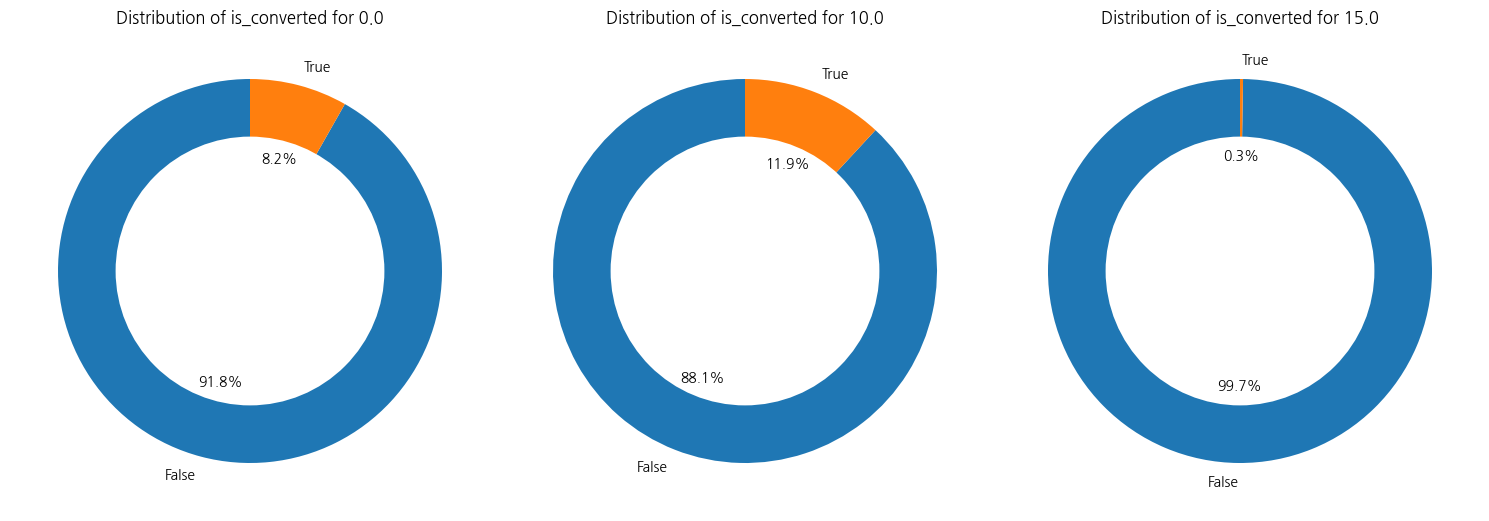

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# it_business_area의 고유한 값들을 가져옵니다.
business_areas = df_train_encoded['idit_business_area'].unique()

# 행과 열의 수를 계산합니다.
n = len(business_areas)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))

# axs를 항상 2차원 배열로 처리합니다.
if nrows == 1:
    axs = axs[np.newaxis, :]
if ncols == 1:
    axs = axs[:, np.newaxis]

for i, area in enumerate(business_areas):
    # 특정 business_area에 해당하는 데이터만 선택합니다.
    subset = df_train_encoded[df_train_encoded['idit_business_area'] == area]
    
    # is_converted의 값에 따라 데이터를 그룹화하고 카운트합니다.
    counts = subset['is_converted'].value_counts()
    
    # 도넛 차트를 생성합니다.
    ax = axs[i // ncols, i % ncols]
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Distribution of is_converted for {area}')
    ax.add_artist(plt.Circle((0,0),0.70,fc='white'))

# 빈 subplot을 숨깁니다.
for j in range(i+1, nrows*ncols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()


포함하지 않는 변수들에 대해서 drop

In [88]:
df_train_encoded = df_train_encoded.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], axis=1)
df_test_encoded = df_test_encoded.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], axis=1)

df_train_encoded = df_train_encoded.drop(['ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu'], axis=1)
df_test_encoded = df_test_encoded.drop(['ver_cus', 'ver_pro', 'ver_win_rate_x', 'ver_win_ratio_per_bu'], axis=1)

df_train_encoded = df_train_encoded.drop(['business_area', 'business_subarea', 'product_subcategory'], axis=1)
df_test_encoded = df_test_encoded.drop(['business_area', 'business_subarea', 'product_subcategory'], axis=1)

### 변수중요도

In [89]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트와 테스트 세트로 나누기
X = df_train_encoded.drop(columns=['is_converted'])
y = df_train_encoded['is_converted']

# 80%를 훈련 세트로, 20%를 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 데이터셋 준비
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth': 8, 'learning_rate': 0.1}
num_round = 500
bst = xgb.train(param, dtrain, num_round)

# 특성 중요도 확인
feature_importance = bst.get_score(importance_type='gain')

# 특성 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string())


                          Importance
customer_idx                0.873030
lead_owner                  0.246680
ver_ratio_business_area     0.229190
customer_country.1          0.211443
customer_type               0.209935
response_corporate          0.187375
business_unit               0.166339
ver_win_business_area       0.146799
id_business_area            0.130752
lead_desc_length            0.125226
historical_existing_cnt     0.123687
com_reg_ver_win_rate        0.109241
idit_business_area          0.094235
product_category            0.091101
enterprise                  0.088676
category_modelname          0.087935
expected_timeline           0.086663
customer_country            0.086073
product_modelname           0.085599
customer_job                0.082348
it_business_area            0.081153
customer_position           0.077164
ver_pro_product_category    0.074307
ver_cus_business_area       0.073795
bant_submit                 0.069824
inquiry_type                0.067528


### 상관관계 히트맵

In [90]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bant_submit               59299 non-null  float64
 1   customer_country          59299 non-null  int32  
 2   business_unit             59299 non-null  int32  
 3   com_reg_ver_win_rate      59299 non-null  float64
 4   customer_idx              59299 non-null  int64  
 5   customer_type             59299 non-null  int32  
 6   enterprise                59299 non-null  int32  
 7   historical_existing_cnt   59299 non-null  float64
 8   customer_job              59299 non-null  int32  
 9   lead_desc_length          59299 non-null  int64  
 10  inquiry_type              59299 non-null  int32  
 11  product_category          59299 non-null  int32  
 12  product_modelname         59299 non-null  int32  
 13  customer_country.1        59299 non-null  int32  
 14  custom

In [91]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5271 non-null   int64  
 1   bant_submit               5271 non-null   float64
 2   customer_country          5271 non-null   int32  
 3   business_unit             5271 non-null   int32  
 4   com_reg_ver_win_rate      5271 non-null   float64
 5   customer_idx              5271 non-null   int64  
 6   customer_type             5271 non-null   int32  
 7   enterprise                5271 non-null   int32  
 8   historical_existing_cnt   5271 non-null   float64
 9   customer_job              5271 non-null   int32  
 10  lead_desc_length          5271 non-null   int64  
 11  inquiry_type              5271 non-null   int32  
 12  product_category          5271 non-null   int32  
 13  product_modelname         5271 non-null   int32  
 14  customer

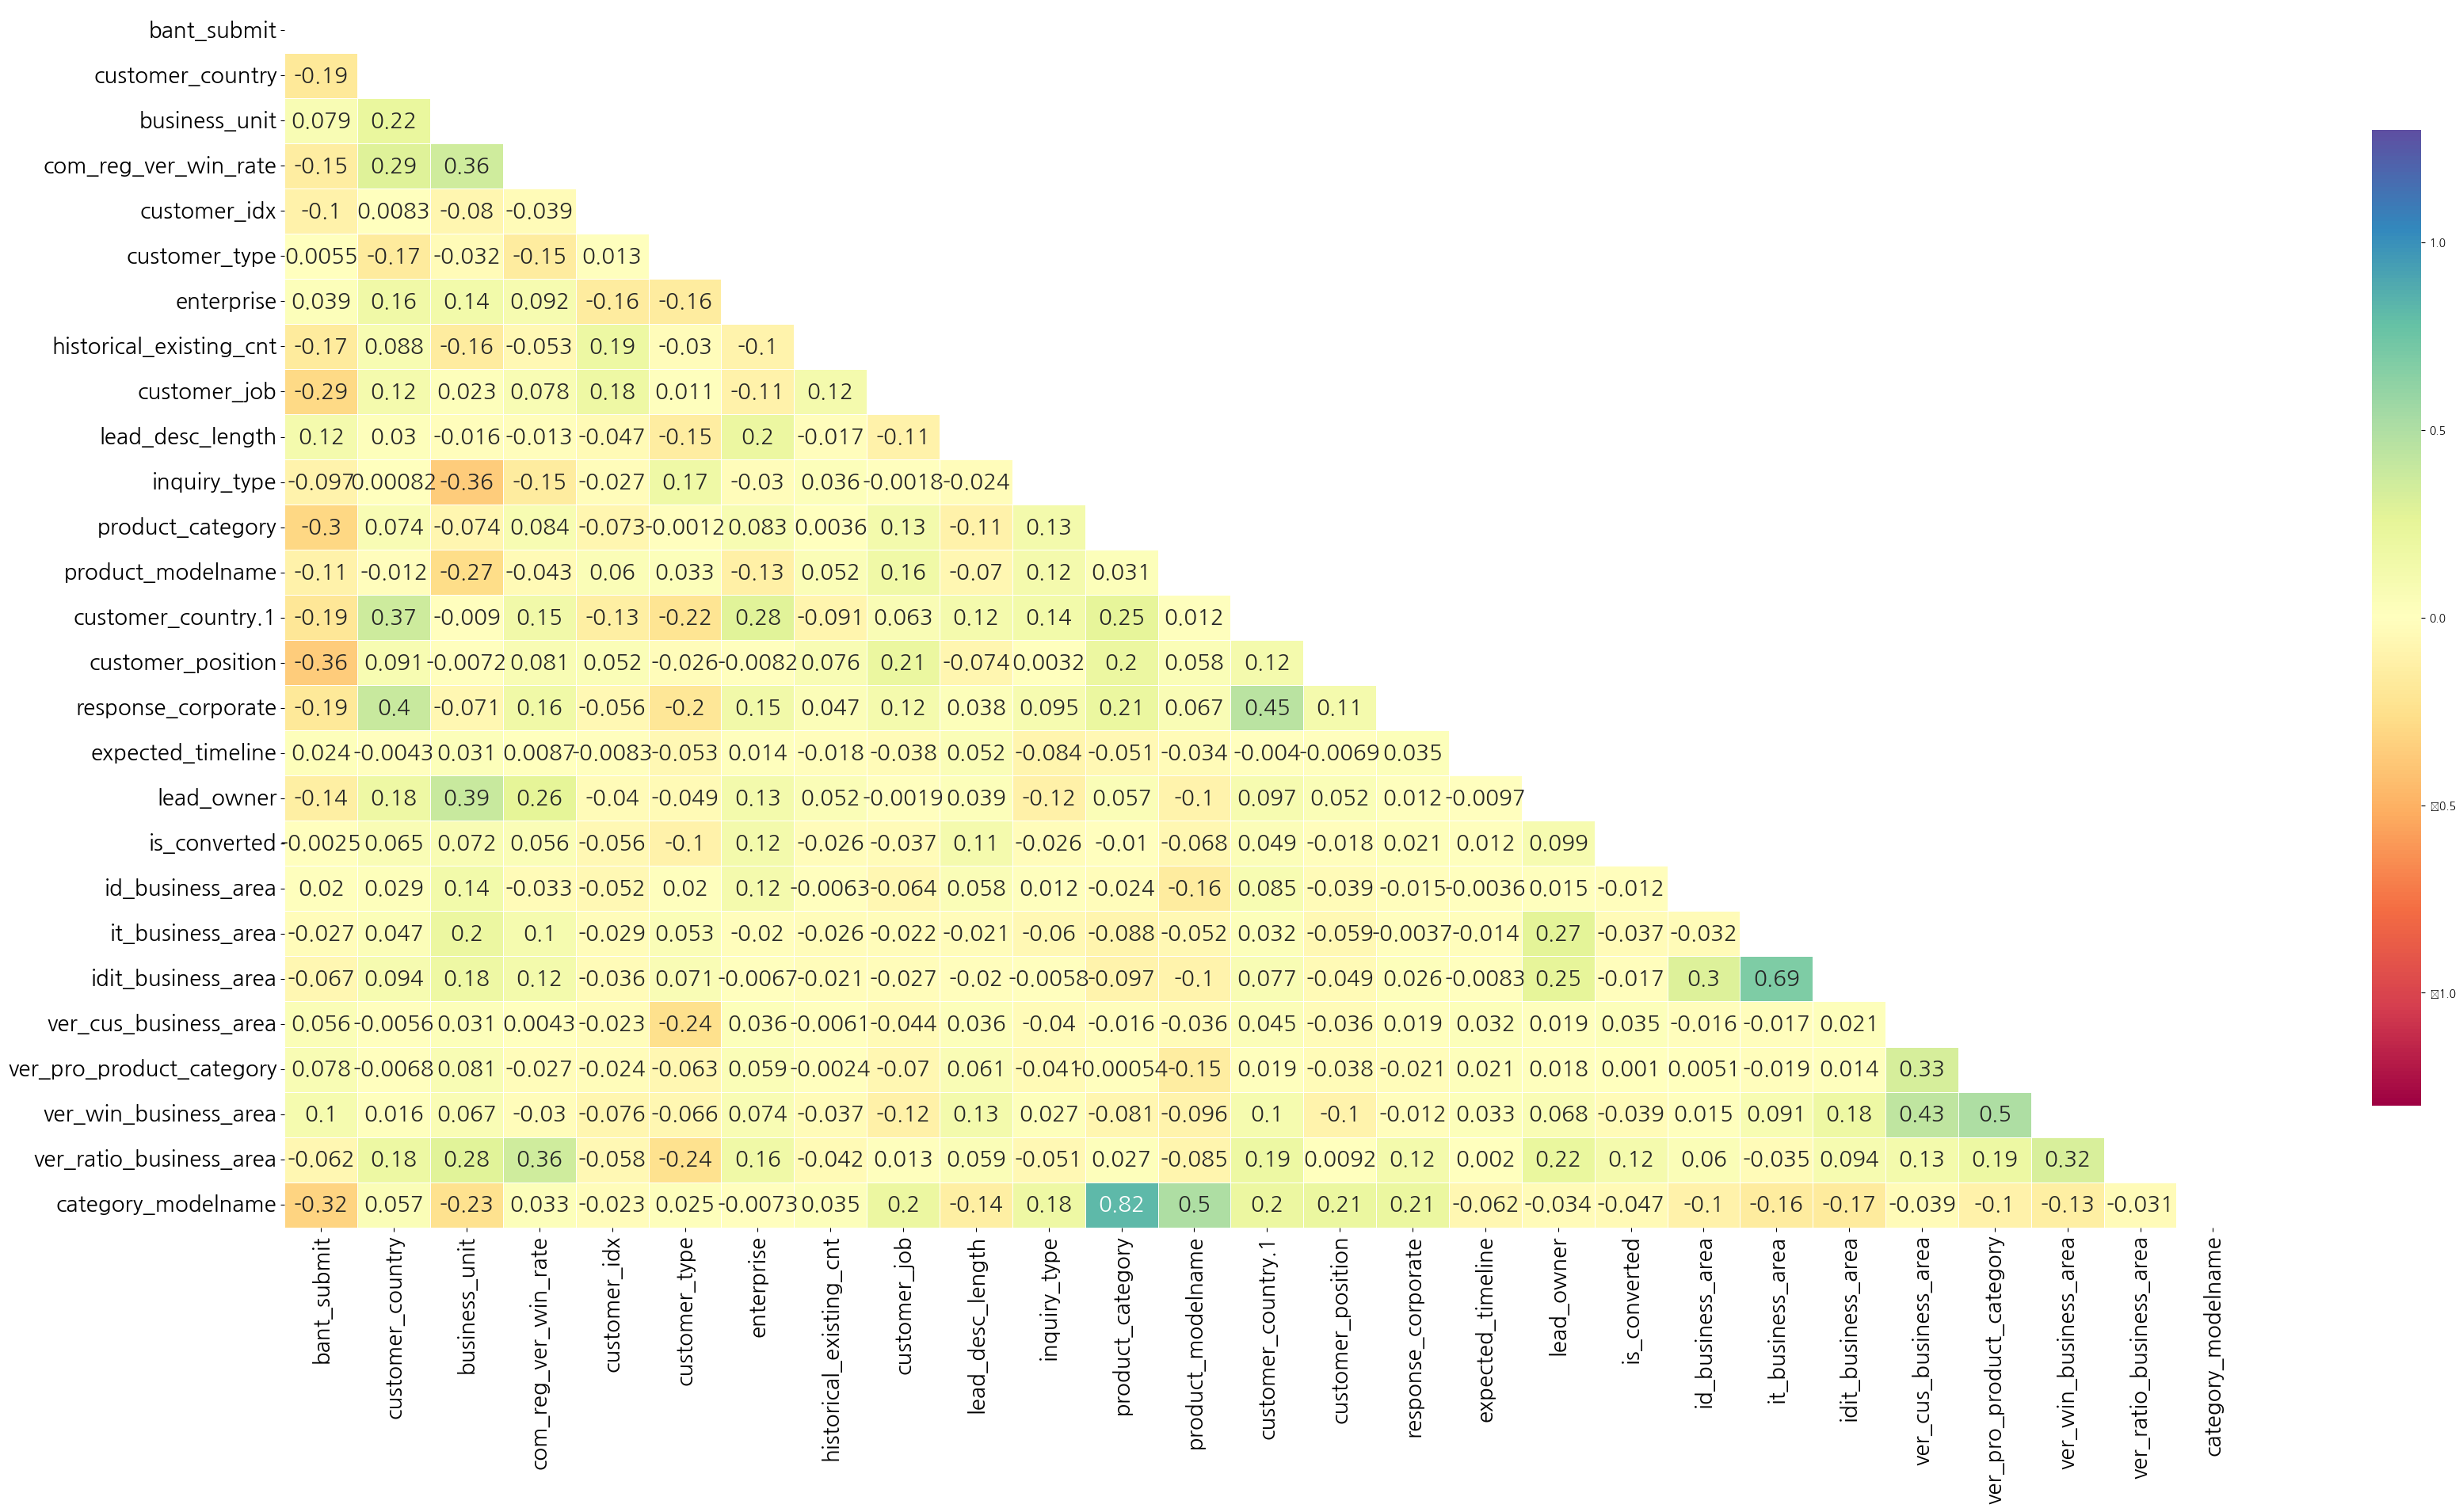

In [92]:
import numpy as np

# 숫자형 변수들 간의 상관관계 계산
corr = df_train_encoded.corr()

# 상관계수 행렬의 상삼각행렬을 마스킹하기 위한 마스크 생성
mask = np.triu(np.ones_like(corr, dtype=bool))

# 히트맵
plt.figure(figsize=(40, 20))

sns.heatmap(corr,
            mask=mask, # 마스크 적용
            annot=True, # 수치(상관관계) 표시
            annot_kws = {'size':20}, # 수치표시 사이즈
            cmap='Spectral', # 색상 변경
            vmin=-1.3, # 색상 팔레트 범위
            vmax=1.3,
            linewidths=.5, # 히트맵의 선 스타일 변경
            cbar_kws={"shrink": .8}) # 히트맵 주변에 색상 바 추가(사이즈 조절 가능)

# 변수 이름의 크기 조절
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     7.421066               bant_submit
1     6.057230          customer_country
2     4.116391             business_unit
3     1.955027      com_reg_ver_win_rate
4     4.748321              customer_idx
5     9.811132             customer_type
6     1.904719                enterprise
7     1.195189   historical_existing_cnt
8     5.579909              customer_job
9     1.521264          lead_desc_length
10   14.719594              inquiry_type
11   31.736431          product_category
12   37.821278         product_modelname
13    3.705513        customer_country.1
14    5.680109         customer_position
15    8.535170        response_corporate
16    7.558561         expected_timeline
17    3.085615                lead_owner
18    1.423592          id_business_area
19    2.396429          it_business_area
20    2.644884        idit_business_area
21    1.373028     ver_cus_business_area
22    1.444194  ver_pro_product_category
23    2.058327  

In [94]:
df_train_encoded = df_train_encoded.drop(['product_modelname'], axis=1)
df_test_encoded = df_test_encoded.drop(['product_modelname'], axis=1)

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     6.029649               bant_submit
1     6.037084          customer_country
2     4.094335             business_unit
3     1.952205      com_reg_ver_win_rate
4     4.541624              customer_idx
5     9.309175             customer_type
6     1.904502                enterprise
7     1.194229   historical_existing_cnt
8     5.409628              customer_job
9     1.508156          lead_desc_length
10   13.292185              inquiry_type
11   21.205843          product_category
12    3.705492        customer_country.1
13    5.466507         customer_position
14    8.372703        response_corporate
15    7.097007         expected_timeline
16    3.060929                lead_owner
17    1.423468          id_business_area
18    2.370501          it_business_area
19    2.643117        idit_business_area
20    1.368311     ver_cus_business_area
21    1.444071  ver_pro_product_category
22    2.058323     ver_win_business_area
23    1.635374  

In [96]:
df_train_encoded = df_train_encoded.drop(['product_category'], axis=1)
df_test_encoded = df_test_encoded.drop(['product_category'], axis=1)

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     6.026510               bant_submit
1     6.019307          customer_country
2     3.963114             business_unit
3     1.951518      com_reg_ver_win_rate
4     4.541368              customer_idx
5     9.281333             customer_type
6     1.890658                enterprise
7     1.194043   historical_existing_cnt
8     5.398614              customer_job
9     1.508051          lead_desc_length
10   13.142997              inquiry_type
11    3.676327        customer_country.1
12    5.428556         customer_position
13    8.337713        response_corporate
14    7.075806         expected_timeline
15    3.048127                lead_owner
16    1.416209          id_business_area
17    2.365521          it_business_area
18    2.641648        idit_business_area
19    1.368297     ver_cus_business_area
20    1.415464  ver_pro_product_category
21    2.055431     ver_win_business_area
22    1.635041   ver_ratio_business_area
23    5.291676  

In [98]:
df_train_encoded = df_train_encoded.drop(['inquiry_type'], axis=1)
df_test_encoded = df_test_encoded.drop(['inquiry_type'], axis=1)

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     5.595430               bant_submit
1     5.954715          customer_country
2     3.727497             business_unit
3     1.947897      com_reg_ver_win_rate
4     4.497771              customer_idx
5     7.849115             customer_type
6     1.889903                enterprise
7     1.193921   historical_existing_cnt
8     5.367066              customer_job
9     1.506556          lead_desc_length
10    3.627167        customer_country.1
11    5.354593         customer_position
12    8.213844        response_corporate
13    7.002530         expected_timeline
14    3.038005                lead_owner
15    1.412525          id_business_area
16    2.365487          it_business_area
17    2.641205        idit_business_area
18    1.366569     ver_cus_business_area
19    1.414004  ver_pro_product_category
20    2.050777     ver_win_business_area
21    1.626109   ver_ratio_business_area
22    5.110243        category_modelname


### 최종적으로 선정된 변수

In [73]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bant_submit               59299 non-null  float64
 1   customer_country          59299 non-null  int32  
 2   business_unit             59299 non-null  int32  
 3   com_reg_ver_win_rate      59299 non-null  float64
 4   customer_idx              59299 non-null  int64  
 5   customer_type             59299 non-null  int32  
 6   enterprise                59299 non-null  int32  
 7   historical_existing_cnt   59299 non-null  float64
 8   customer_job              59299 non-null  int32  
 9   lead_desc_length          59299 non-null  int64  
 10  customer_country.1        59299 non-null  int32  
 11  customer_position         59299 non-null  int32  
 12  response_corporate        59299 non-null  int32  
 13  expected_timeline         59299 non-null  int32  
 14  lead_o

In [74]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5271 non-null   int64  
 1   bant_submit               5271 non-null   float64
 2   customer_country          5271 non-null   int32  
 3   business_unit             5271 non-null   int32  
 4   com_reg_ver_win_rate      5271 non-null   float64
 5   customer_idx              5271 non-null   int64  
 6   customer_type             5271 non-null   int32  
 7   enterprise                5271 non-null   int32  
 8   historical_existing_cnt   5271 non-null   float64
 9   customer_job              5271 non-null   int32  
 10  lead_desc_length          5271 non-null   int64  
 11  customer_country.1        5271 non-null   int32  
 12  customer_position         5271 non-null   int32  
 13  response_corporate        5271 non-null   int32  
 14  expected

In [100]:
df_train_encoded.to_csv('./data/Ch3/df_train_encoded.csv', index=False)
df_test_encoded.to_csv('./data/Ch3/df_test_encoded.csv', index=False)

.